In this notebook I want to present implementation of raw K-Nearest Neighbours algorithm with both distances L1, L2. I will show how algorithm works on Iris dataset (https://en.wikipedia.org/wiki/Iris_flower_data_set).

In [71]:
import os
import csv
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from tqdm import tqdm

### Constants

In [72]:
DATA_URL = "https://raw.githubusercontent.com/pandas-dev/pandas/master/pandas/tests/data/iris.csv"
IRIS_FILE = "./iris.csv"

### Prepare data

#### Download Iris dataset

In [73]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not os.path.isfile(IRIS_FILE):
    with DLProgress(unit="B", unit_scale=True, miniters=1, desc="Iris dataset") as pbar:
        urlretrieve(DATA_URL, IRIS_FILE, pbar.hook)

#### Loading files & extracting data

In [74]:
iris_headers = None
iris_rows = None
iris_labels = None

with open(IRIS_FILE, "r") as csv_file:
    temp = list(csv.reader(csv_file))
    iris_headers = temp[0]
    iris_rows = np.array([np.array(row[:-1]).astype(np.float32) for row in temp[1:]])
    iris_labels = [row[-1] for row in temp[1:]]

#### Data presentation

In [75]:
rows_to_show = 10

In [76]:
print("Headers:" + str(iris_headers))

Headers:['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Name']


In [77]:
for i in range(0, rows_to_show):
    print("Sample no. " + str(i) + " - " + str(iris_rows[i]))

Sample no. 0 - [ 5.0999999   3.5         1.39999998  0.2       ]
Sample no. 1 - [ 4.9000001   3.          1.39999998  0.2       ]
Sample no. 2 - [ 4.69999981  3.20000005  1.29999995  0.2       ]
Sample no. 3 - [ 4.5999999  3.0999999  1.5        0.2      ]
Sample no. 4 - [ 5.          3.5999999   1.39999998  0.2       ]
Sample no. 5 - [ 5.4000001   3.9000001   1.70000005  0.40000001]
Sample no. 6 - [ 4.5999999   3.4000001   1.39999998  0.30000001]
Sample no. 7 - [ 5.         3.4000001  1.5        0.2      ]
Sample no. 8 - [ 4.4000001   2.9000001   1.39999998  0.2       ]
Sample no. 9 - [ 4.9000001  3.0999999  1.5        0.1      ]


In [78]:
for i in range(0, rows_to_show):
    print("Label no. " + str(i) + " - " + str(iris_labels[i]))

Label no. 0 - Iris-setosa
Label no. 1 - Iris-setosa
Label no. 2 - Iris-setosa
Label no. 3 - Iris-setosa
Label no. 4 - Iris-setosa
Label no. 5 - Iris-setosa
Label no. 6 - Iris-setosa
Label no. 7 - Iris-setosa
Label no. 8 - Iris-setosa
Label no. 9 - Iris-setosa


In [79]:
print("Number of samples: " + str(len(iris_rows)))

Number of samples: 150


#### Data Preprocessing - prepare to feed into KNN

Extracting number of classes, and classes names

In [80]:
classes_names = set(iris_labels)
classes_num = len(classes_names)

Dividing classes into lists assigned to class name

In [81]:
samples_divided_by_classes = dict()
for row, label in zip(iris_rows, iris_labels):
    if label not in samples_divided_by_classes.keys():
        samples_divided_by_classes.update({label: list()})
    
    samples_divided_by_classes[label].append(row)

Spliting into train and test sets.

In [82]:
test_samples_ratio = 0.8

In [83]:
train_rows = list()
test_rows = list()

train_labels = list()
test_labels = list()

print("Counting number of remaining samples to split: ")
num_of_samples_per_class = list()
for key in samples_divided_by_classes.keys():
    num_of_samples_per_class.append(len(samples_divided_by_classes[key]))
    print("- Class: " + key + ", num samples: " + str(len(samples_divided_by_classes[key])))

print("\nTrimming data: ")
for sample_class in classes_names:
    trimmed = samples_divided_by_classes[sample_class][:min(num_of_samples_per_class)]
    samples_divided_by_classes[sample_class] = trimmed
    print("- Trimming samples of class '" 
          + sample_class + "'to " + str(min(num_of_samples_per_class)) + ".")

print("\nCreating training set: ")
split_index = int(min(num_of_samples_per_class) * test_samples_ratio)
for sample_class in classes_names:
    train_rows.extend(samples_divided_by_classes[sample_class][:split_index])
    train_labels = [sample_class for sample in train_rows]
    print("- Adding " + str(len(samples_divided_by_classes[sample_class][:split_index])) 
          + " samples of class '" + sample_class + "' to training set.")
    samples_divided_by_classes[sample_class] = samples_divided_by_classes[sample_class][split_index:]
    
print("\nCreating test set: ")
for sample_class in classes_names:
    test_rows.extend(samples_divided_by_classes[sample_class])
    test_labels = [sample_class for sample in test_rows]
    print("- Adding " + str(len(samples_divided_by_classes[sample_class])) 
          + " samples of class '" + sample_class + "' to test set.")    
    
print("\nConverting types to ndarray.")
train_rows = np.array(train_rows)
test_rows = np.array(test_rows)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

Counting number of remaining samples to split: 
- Class: Iris-setosa, num samples: 50
- Class: Iris-versicolor, num samples: 50
- Class: Iris-virginica, num samples: 50

Trimming data: 
- Trimming samples of class 'Iris-virginica'to 50.
- Trimming samples of class 'Iris-setosa'to 50.
- Trimming samples of class 'Iris-versicolor'to 50.

Creating training set: 
- Adding 40 samples of class 'Iris-virginica' to training set.
- Adding 40 samples of class 'Iris-setosa' to training set.
- Adding 40 samples of class 'Iris-versicolor' to training set.

Creating test set: 
- Adding 10 samples of class 'Iris-virginica' to test set.
- Adding 10 samples of class 'Iris-setosa' to test set.
- Adding 10 samples of class 'Iris-versicolor' to test set.

Converting types to ndarray.


In [84]:
print("Train data samples: " + str(len(train_rows)))
print("Test data samples: " + str(len(test_rows)))

Train data samples: 120
Test data samples: 30


### K Nearest Neighbours - raw implementation

In [85]:
class KNN:
    """Implementation of K-Nearest Neighbours algorithm.
    
    Arguments:
    ---------
    k: int
        Number of nearest neighbours that should be used for prediction sample.
    similarity_function: string
        Function that will be used to calculate similarity between each feature of inserted 
        sample for prediction and samples with already known labels.
    """    
    
    SIMILAIRTY_MANHATTAN = "l1_distance"
    SIMILARITY_EUCLIDEAN = "l2_distance"

    def __init__(self, k=1, similarity_function=SIMILARITY_EUCLIDEAN):
        self.k = k
        self.similarity_function = similarity_function
        
    @staticmethod
    def _l1_manhattan_distance(p, q):
        """Implementation of similarity function using L1 - Manhattan Distance."""
        return np.sum(np.abs(p - q), 1)
    
    @staticmethod
    def _l2_euclidean_distance(p, q):
        """Implementation of similarity function using L2 - Euclidean Distance."""
        return np.sqrt(np.sum(np.square(p - q), 1))
    
    def _get_nearest_neighbors(self, train_data, train_labels, data_for_prediction):
        """Function calculates distance between each sample in 'data_for_prediction' and each
        sample in 'train_data' based on set self.similarity_function. Then results are sorted
        for each sample which should receive prediction and K closest samples from 'train_data'
        are picked and returned as a list assigned to sample which should receive prediction."""
        neighbors = list()
        for i in range(0, len(data_for_prediction)):
            # Calculating similarity between sample that should receive prediction 
            # and every sample in train_data
            if self.similarity_function == self.SIMILAIRTY_MANHATTAN:
                sample_distances = self._l1_manhattan_distance(train_data, data_for_prediction[i])
            elif self.similarity_function == self.SIMILARITY_EUCLIDEAN:
                sample_distances = self._l2_euclidean_distance(train_data, data_for_prediction[i])
            else:
                raise Exception("Unsupported similarity function: " 
                                + str(self.self.similarity_function))

            # Picking K-Neighbours - self.k indexes of closest samples from train_data
            # to sample which should receive prediction
            indexes_of_closest_k_samples = sample_distances.argsort()[:self.k]
            sample_distances = train_labels[indexes_of_closest_k_samples]
            neighbors.append(sample_distances)

        return neighbors

    def _get_responses(self, all_neighbors):
        """For each sample that should return prediction - counts occurance of each label. 
        Returns the one which appears most often as prediction for that sample."""
        responses = list()
        for sample_neighbors in all_neighbors:
            sample_votes = dict()

            # Counting neighbour occurances
            for neighbor in sample_neighbors:
                if neighbor in sample_votes:
                    sample_votes[neighbor] += 1
                else:
                    sample_votes[neighbor] = 1

            # Picking most often appearing neighbour in 'all_neighbour' list
            neighbor_with_most_votes = max(sample_votes, key=sample_votes.get)
            responses.append(neighbor_with_most_votes)

        return responses

    def predict(self, train_data, train_labels, data_for_prediction):
        """Returning prediction for each sample in 'data_for_prediction' list."""
        neighbors = self._get_nearest_neighbors(train_data, train_labels, data_for_prediction)
        return self._get_responses(neighbors)

### Using model for prediction

Helper function

In [86]:
def accuracy(a, b):
    """Function that compares values in two lists(that should be of same length) and returns
    numbers of values which are the same."""
    correct_predictions = 0
    for a_value, b_value in zip(a, b):
        if a_value == b_value:
            correct_predictions += 1
    return correct_predictions / len(a)

In [87]:
def binarize_labels(labels):
    """Function which takes as argument n-element list of labels. Reduces duplicates and
    assigns integer to each label in reduced list. Integer is equal to position d"""
    all_labels = list(set(labels))
    return np.array([all_labels.index(label) for label in labels])

Creating model

In [88]:
knn = KNN(k=7)

Predicting 

In [89]:
predictions = knn.predict(train_rows, train_labels, test_rows)
test_accuracy = accuracy(predictions, test_labels)

print("Accuracy for test set: " + str(test_accuracy)) 

Accuracy for test set: 1.0


Prediction plot

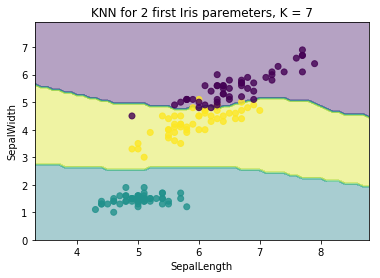

In [90]:
X = iris_rows[:, [0, 2]]
y = binarize_labels(iris_labels)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = knn.predict(X, y, np.c_[xx.ravel(), yy.ravel()])

Z = np.array(Z).reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
plt.xlabel("SepalLength")
plt.ylabel("SepalWidth")
plt.title("KNN for 2 first Iris paremeters, K = " + str(knn.k))

plt.show()